In [ ]:
# Aqui está o código completo ajustado para extrair a probabilidade corretamente usando vector_to_array.
# Cole tudo em uma célula do notebook.

%matplotlib inline

import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit, col
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve

# ─────────────────── 1) PATHS E SPARK ───────────────────
PIPELINE_FE    = "../dados/pipeline_fe"
READY_SMALL     = "../dados/chicago_ready_small.parquet"
FULL_MODEL_OUT = "../dados/full_model"

spark = (
    SparkSession.builder
    .appName("CrimeTrainFull_ComPlots_Notebook")
    .config("spark.sql.shuffle.partitions", "16")
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "8g")\
    .getOrCreate()
)


# ─────────────────── CARREGAR df_mall ───────────────────
df_mall = spark.read.parquet(READY_SMALL)
fe= PipelineModel.load(PIPELINE_FE)   

# ───────────────────  SPLIT / CACHE / CONTAGEM ───────────────────
train, test = df_mall.randomSplit([0.8, 0.2], seed=42)


# ─────────────────── DEFINIR EVALUATOR AUC ───────────────────
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",   # usa “probability” como rawPrediction
    metricName="areaUnderROC"
)

# Contar quantos exemplos de cada classe existem em 'train' (não-balanceado)
counts = train.groupBy("label").count().collect()
# Exemplo de 'counts': [Row(label=0, count=557471), Row(label=1, count=161705)]
n0 = [row["count"] for row in counts if row["label"] == 0][0]
n1 = [row["count"] for row in counts if row["label"] == 1][0]

print(f"Contagem em train (não-balanceado): label=0 → {n0}, label=1 → {n1}")

# Calcular pesos inversamente proporcionais às frequências
weight_for_0 = (n0 + n1) / (2.0 * n0)
weight_for_1 = (n0 + n1) / (2.0 * n1)

print(f"Peso para classe 0: {weight_for_0:.4f}")
print(f"Peso para classe 1: {weight_for_1:.4f}")

# Injetar coluna "weight" em train_small
train_weighted = train.withColumn(
    "weight",
    when(col("label") == 0, lit(weight_for_0))
    .otherwise(lit(weight_for_1))
)


train_weighted.cache()

Contagem em train (não-balanceado): label=0 → 93313, label=1 → 26968
Peso para classe 0: 0.6445
Peso para classe 1: 2.2301


DataFrame[features: vector, label: int, weight: double]

In [2]:
# 1) Definição do modelo
logreg = LogisticRegression(
    maxIter=20,
    regParam=0.01,
    elasticNetParam=0.5,
    labelCol="label",
    featuresCol="features",
    weightCol="weight"     
)

# 2) Treino
print("\n==== Treinando LogReg ====")
t0 = time.time()
logreg_model = logreg.fit(train_weighted)
dur = time.time() - t0
print(f"→ LogReg treinado em {dur/60:.2f} min")

# 3) Avaliação no conjunto de teste
pred_logreg = logreg_model.transform(test)
auc_logreg = evaluator.evaluate(pred_logreg)
print(f"★ AUC (LogReg) no test: {auc_logreg:.4f}")

# 4) Coleta prob1/label para curva ROC
pred_logreg_arr = pred_logreg.withColumn("prob_array", vector_to_array("probability"))
pdf_logreg = (
    pred_logreg_arr
    .withColumn("prob1", pred_logreg_arr["prob_array"][1])
    .select("prob1", "label")
    .toPandas()
)
y_score_logreg = pdf_logreg["prob1"].astype(float).values
y_true_logreg  = pdf_logreg["label"].astype(float).values
fpr_logreg, tpr_logreg, _ = roc_curve(y_true_logreg, y_score_logreg)

# 5) Armazenando no dicionário para comparações posteriores
aucs = {"LogReg": auc_logreg}
roc_data = {"LogReg": (fpr_logreg.tolist(), tpr_logreg.tolist())}

# (Opcional) Imprima esses dados para conferência
print(f"LogReg → AUC: {auc_logreg:.4f}")


==== Treinando LogReg ====
→ LogReg treinado em 0.08 min
★ AUC (LogReg) no test: 0.8299
LogReg → AUC: 0.8299


In [3]:
# 1) Definição do modelo
rf = RandomForestClassifier(
    numTrees=100,
    maxDepth=8,
    subsamplingRate=0.7,
    featureSubsetStrategy="sqrt",
    labelCol="label",
    featuresCol="features",
    weightCol="weight"
)

# 2) Treino
print("\n==== Treinando RandomForest ====")
t0 = time.time()
rf_model = rf.fit(train_weighted)
dur = time.time() - t0
print(f"→ RandomForest treinado em {dur/60:.2f} min")

# 3) Avaliação no conjunto de teste
pred_rf = rf_model.transform(test)
evaluator_rf = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
auc_rf = evaluator_rf.evaluate(pred_rf)
print(f"★ AUC (RandomForest) no test: {auc_rf:.4f}")

# 4) Coleta prob1/label para curva ROC
pred_rf_arr = pred_rf.withColumn("prob_array", vector_to_array("probability"))
pdf_rf = (
    pred_rf_arr
    .withColumn("prob1", pred_rf_arr["prob_array"][1])
    .select("prob1", "label")
    .toPandas()
)
y_score_rf = pdf_rf["prob1"].astype(float).values
y_true_rf  = pdf_rf["label"].astype(float).values
fpr_rf, tpr_rf, _ = roc_curve(y_true_rf, y_score_rf)

# 5) Armazenando no dicionário (se já existir 'aucs', apenas adicione)
aucs["RandomForest"] = auc_rf
roc_data["RandomForest"] = (fpr_rf.tolist(), tpr_rf.tolist())

# (Opcional) Imprima esses dados para conferência
print(f"RandomForest → AUC: {auc_rf:.4f}")


==== Treinando RandomForest ====


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o338.fit

In [6]:
# 1) Definição do modelo
gbt = GBTClassifier(
    maxIter=50,
    maxDepth=7,
    subsamplingRate=0.8,
    stepSize=0.1,
    labelCol="label",
    featuresCol="features",
    weightCol="weight"
)

# 2) Treino
print("\n==== Treinando GBT ====")
t0 = time.time()
gbt_model = gbt.fit(train_weighted)
dur = time.time() - t0
print(f"→ GBT treinado em {dur/60:.2f} min")

# 3) Avaliação no conjunto de teste
pred_gbt = gbt_model.transform(test)
evaluator_gbt = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
auc_gbt = evaluator_gbt.evaluate(pred_gbt)
print(f"★ AUC (GBT) no test: {auc_gbt:.4f}")

# 4) Coleta prob1/label para curva ROC
pred_gbt_arr = pred_gbt.withColumn("prob_array", vector_to_array("probability"))
pdf_gbt = (
    pred_gbt_arr
    .withColumn("prob1", pred_gbt_arr["prob_array"][1])
    .select("prob1", "label")
    .toPandas()
)
y_score_gbt = pdf_gbt["prob1"].astype(float).values
y_true_gbt  = pdf_gbt["label"].astype(float).values
fpr_gbt, tpr_gbt, _ = roc_curve(y_true_gbt, y_score_gbt)

# 5) Armazenando no dicionário (já contendo LogReg e RF)
aucs["GBT"] = auc_gbt
roc_data["GBT"] = (fpr_gbt.tolist(), tpr_gbt.tolist())

# (Opcional) Imprima esses dados para conferência
print(f"GBT → AUC: {auc_gbt:.4f}")



==== Treinando GBT ====
→ GBT treinado em 1.24 min
★ AUC (GBT) no test: 0.8639
GBT → AUC: 0.8639


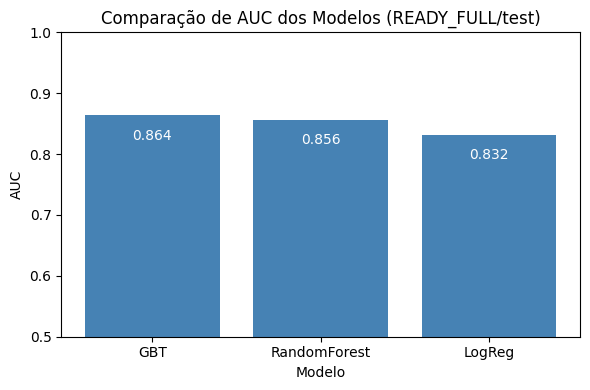

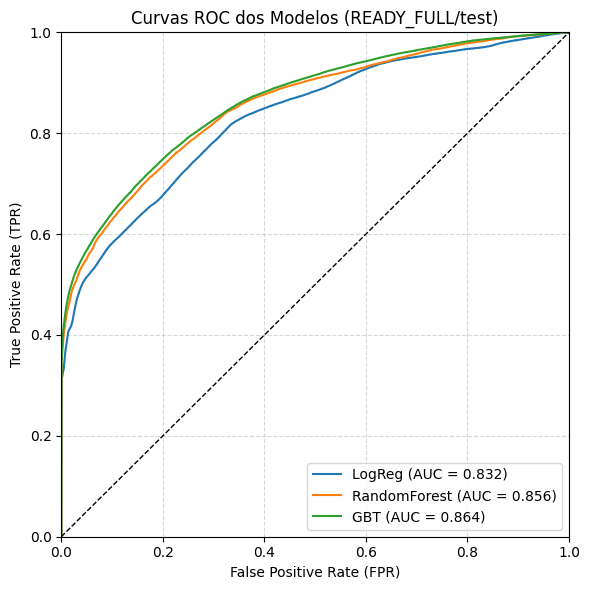

In [ ]:

# 4.1) Plot de barras comparando AUCs
def plot_auc_comparison_inline(aucs_dict):
    df_auc = pd.DataFrame.from_dict(aucs_dict, orient="index", columns=["AUC"])
    df_auc = df_auc.sort_values("AUC", ascending=False)
    plt.figure(figsize=(6,4))
    bars = plt.bar(df_auc.index, df_auc["AUC"], color="steelblue")
    plt.ylim(0.5, 1.0)
    plt.title("Comparação de AUC dos Modelos (READY_SMALL/test)")
    plt.ylabel("AUC")
    plt.xlabel("Modelo")
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.0,
            h - 0.04,
            f"{h:.3f}",
            ha="center",
            color="white",
            fontsize=10
        )
    plt.tight_layout()
    plt.show()

# 4.2) Plot de curvas ROC sobrepostas
def plot_roc_curves_inline(roc_dict, aucs_dict):
    plt.figure(figsize=(6,6))
    for name, (fpr, tpr) in roc_dict.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC = {aucs_dict[name]:.3f})")
    plt.plot([0,1], [0,1], "k--", linewidth=1)  # linha diagonal de baseline
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("Curvas ROC dos Modelos (READY_SMALL/test)")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Chame as funções após executar os três blocos de treino:
plot_auc_comparison_inline(aucs)
plot_roc_curves_inline(roc_data, aucs)



In [8]:
# Identifique qual foi o melhor modelo:
best_name, best_auc = max(aucs.items(), key=lambda kv: kv[1])
print(f"\n🏆 Melhor modelo selecionado: {best_name} (AUC = {best_auc:.4f})")

# Use a instância 'best_model' correspondente (guarde-a nos blocos anteriores)
# Supondo que você tenha salvo as instâncias em variáveis: logreg_model, rf_model, gbt_model
if best_name == "LogReg":
    chosen_model = logreg_model
elif best_name == "RandomForest":
    chosen_model = rf_model
else:
    chosen_model = gbt_model


chosen_model_fixed = chosen_model.copy({chosen_model.featuresCol: "pcaFeatures"})

full_pipeline = Pipeline(stages=[fe, chosen_model_fixed])
full_pipeline.write().overwrite().save(FULL_MODEL_OUT)

spark.stop()


🏆 Melhor modelo selecionado: GBT (AUC = 0.8639)
